# Bank Reviews - Complaints Analysis

### Importing Packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

### Importing the dataset

In [2]:
data = pd.read_excel('BankReviews.xlsx')

In [3]:
data.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


## Data Processing

In [5]:
# Dropping date and rearranging columns
data = data[['Stars','BankName','Reviews']]

In [6]:
data['Reviews'] = data['Reviews'].astype(str)

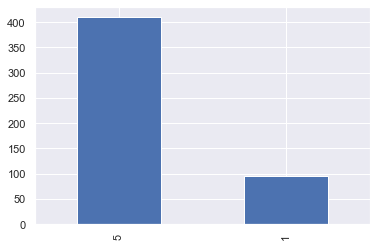

In [7]:
data['Stars'].value_counts().plot(kind='bar')
plt.show()

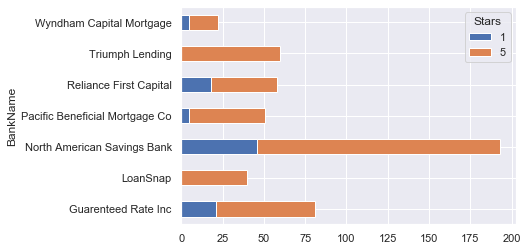

In [8]:
pd.crosstab(index=data.BankName, columns=data.Stars).plot(kind='barh', stacked=True)
plt.show()

### Cleaning the texts

In [9]:
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

ps = PorterStemmer()
all_stopwords = stopwords.words('english')
#all_stopwords.remove('not')

In [10]:
def clean_text(data, col):
    corpus = []
    for i in range(0, data.shape[0]):
        text = re.sub('[^a-zA-Z]', ' ', data[col][i]) # removing symbols
        text = text.lower() # lower case
        text = text.split() # list of split
        text = [ps.stem(word) for word in text if not word in set(all_stopwords)] # keep root word and remove stopwords
        #text = [word for word in text if not word in set(all_stopwords)]
        text = ' '.join(text)
        #data.loc[i,'Clean_'+col] = text
        corpus.append(text) # final clean review
    return(corpus)

In [11]:
data['Clean_Reviews'] = clean_text(data, 'Reviews')

In [12]:
data.head()

,Stars,BankName,Reviews,Clean_Reviews
0,5,Wyndham Capital Mortgage,"Great job, Wyndham Capital! Each person was pr...",great job wyndham capit person profession help...
1,5,Wyndham Capital Mortgage,Matthew Richardson is professional and helpful...,matthew richardson profession help help us fin...
2,5,Wyndham Capital Mortgage,We had a past experience with Wyndham Mortgage...,past experi wyndham mortgag would without ques...
3,5,Wyndham Capital Mortgage,We have been dealing with Brad Thomka from the...,deal brad thomka begin start stress time us he...
4,5,Wyndham Capital Mortgage,I can't express how grateful I am for the supp...,express grate support zach provid famili home ...


## Most frequent words (key positive/negative words)

In [13]:
word_count = {}
for tokens in data['Clean_Reviews']:
    #tokens = re.sub('[^a-zA-Z]', ' ', tokens) #for unclean column
    tokens = nltk.wordpunct_tokenize(tokens)
    for token in tokens:
        #if token.lower() not in all_stopwords: #for unclean column
        if token in word_count:
            word_count[token] += 1
        else:
            word_count[token] = 1

In [14]:
# Converting word_count into the dataframe
word_freq = pd.DataFrame(word_count.items(), columns=['words','count'])
word_freq = word_freq.sort_values('count', ascending=False).reset_index(drop=True)
word_freq.head()

,words,count
0,loan,331
1,work,298
2,close,265
3,process,262
4,time,247


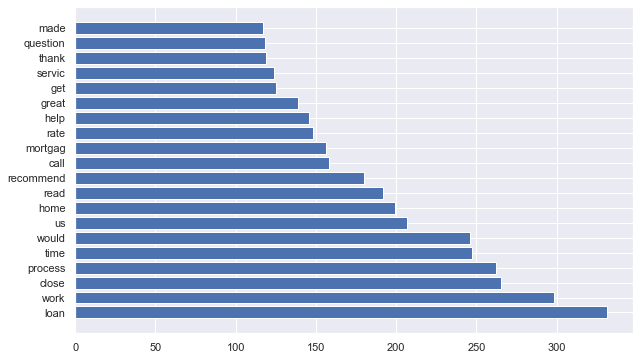

In [15]:
plt.figure(figsize=(10,6))
plt.barh(word_freq['words'].head(20), word_freq['count'].head(20))
#plt.xticks(rotation = 90)
plt.show()

In [16]:
#pip install wordcloud
from wordcloud import WordCloud ,STOPWORDS

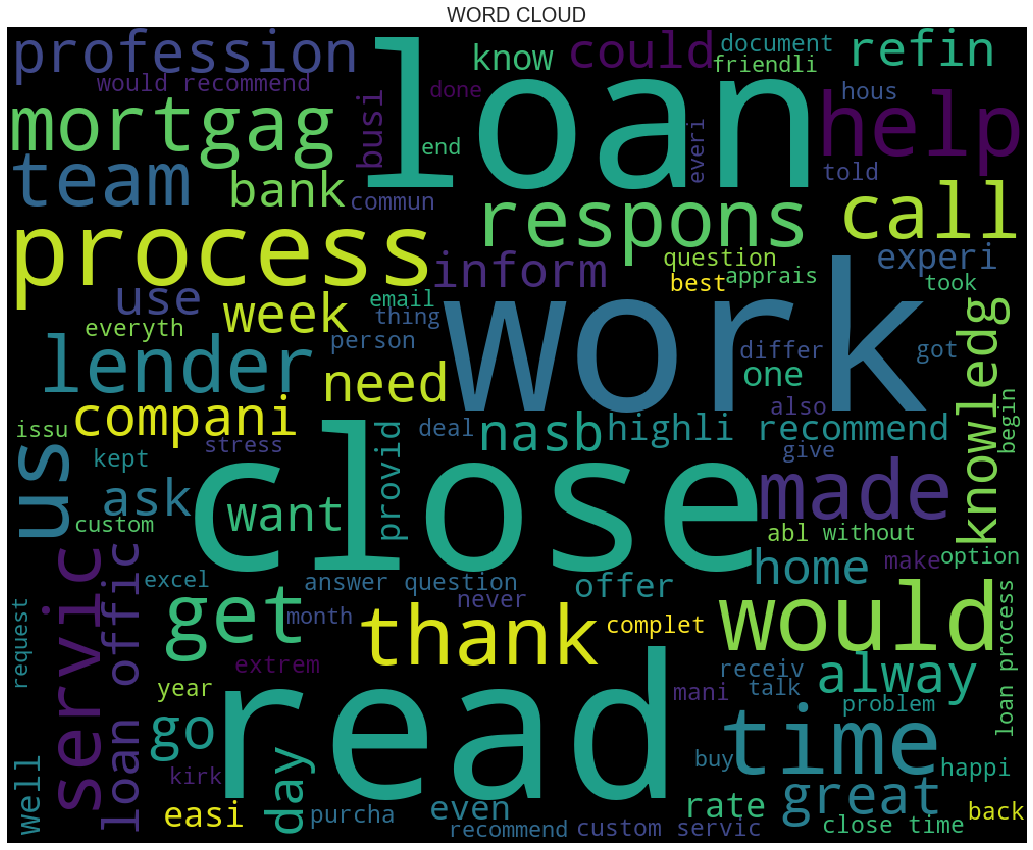

In [17]:
wordcloud = WordCloud(background_color='black',
                      stopwords=[],
                      max_words=100,
                      max_font_size=200, 
                      width=1000, height=800).generate(' '.join(data['Clean_Reviews']))

plt.figure(figsize = (20,15))
plt.imshow(wordcloud)
plt.title("WORD CLOUD",fontsize=20)
plt.axis('off')
plt.show()

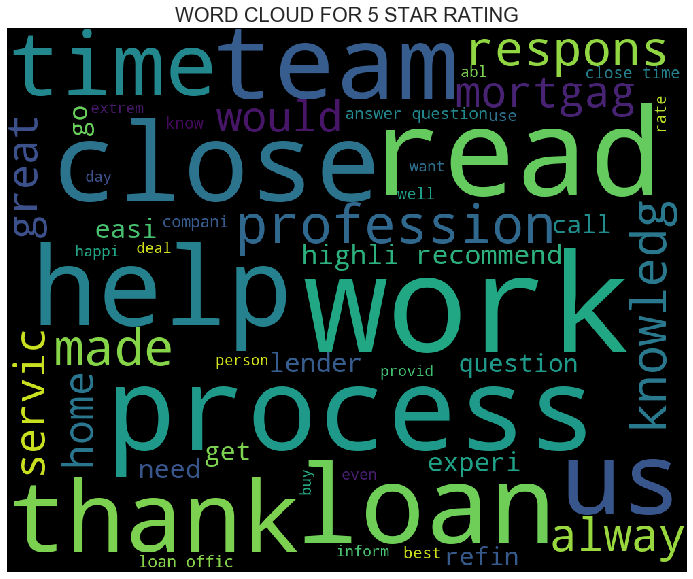

In [18]:
# word cloud for 5 star rating
wordcloud = WordCloud(background_color='black',
                      stopwords=[],
                      max_words=50,
                      max_font_size=200,
                      width=1000, height=800).generate(' '.join(data.loc[data.Stars==5].Clean_Reviews))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD FOR 5 STAR RATING",fontsize=20)
plt.axis("off")
plt.show()

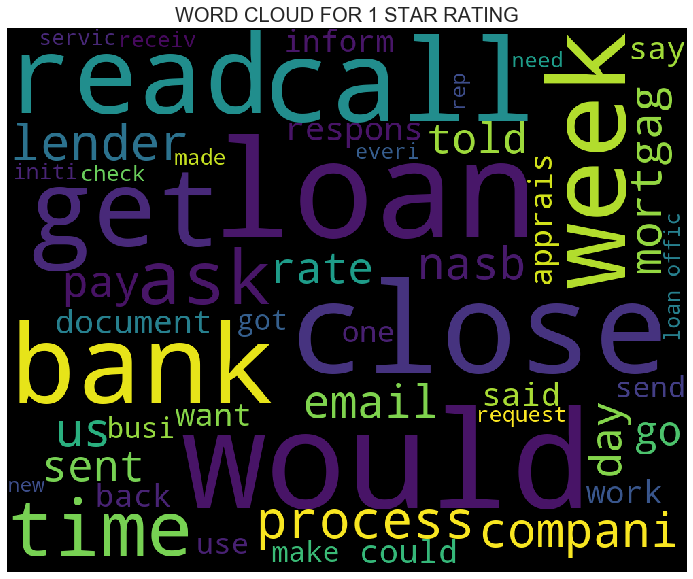

In [19]:
# word cloud for 1 star rating
wordcloud = WordCloud(background_color='black',
                      stopwords=[],
                      max_words=50,
                      max_font_size=200,
                      width=1000,height=800).generate(' '.join(data.loc[data.Stars==1].Clean_Reviews))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD FOR 1 STAR RATING", fontsize=20)
plt.axis("off")
plt.show()

## Classification of reviwes into positive, negative and neutral 

In [20]:
data.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

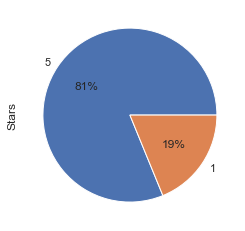

In [21]:
data.Stars.value_counts().plot(kind='pie',autopct= '%1.0f%%')
plt.show()

### Calculating Sentiment analysis using Textblob module

In [22]:
#pip install textblob
from textblob import TextBlob

In [23]:
data['polarity'] = data['Clean_Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)
data["sentiment"] = np.where(data.polarity == 0, "Neutral",np.where(data.polarity < 0,"Negative","Positive"))
data.head()

,Stars,BankName,Reviews,Clean_Reviews,polarity,sentiment
0,5,Wyndham Capital Mortgage,"Great job, Wyndham Capital! Each person was pr...",great job wyndham capit person profession help...,0.800000,Positive
1,5,Wyndham Capital Mortgage,Matthew Richardson is professional and helpful...,matthew richardson profession help help us fin...,0.200000,Positive
2,5,Wyndham Capital Mortgage,We had a past experience with Wyndham Mortgage...,past experi wyndham mortgag would without ques...,-0.116071,Negative
3,5,Wyndham Capital Mortgage,We have been dealing with Brad Thomka from the...,deal brad thomka begin start stress time us he...,-0.095238,Negative
4,5,Wyndham Capital Mortgage,I can't express how grateful I am for the supp...,express grate support zach provid famili home ...,0.000000,Neutral


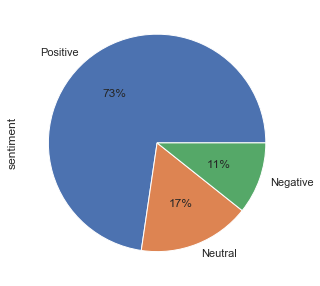

In [24]:
plt.figure(figsize=(12,5))
data['sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')
plt.show()

In [25]:
pd.crosstab(index=data['sentiment'], columns=data['Stars'], margins=True)

Stars,1,5,All
sentiment,,,
Negative,27,27,54
Neutral,18,66,84
Positive,50,317,367
All,95,410,505


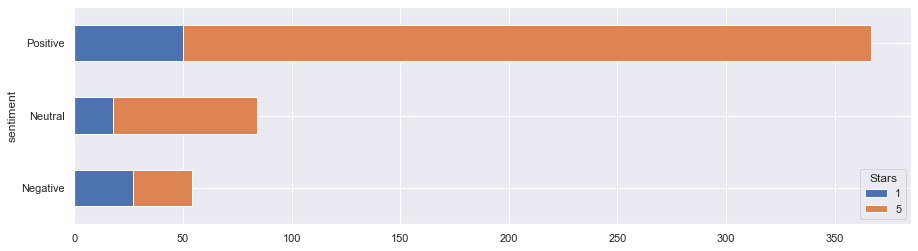

In [26]:
pd.crosstab(index=data.sentiment, columns=data.Stars).plot(kind='barh', stacked=True, figsize=(15,4))
plt.show()

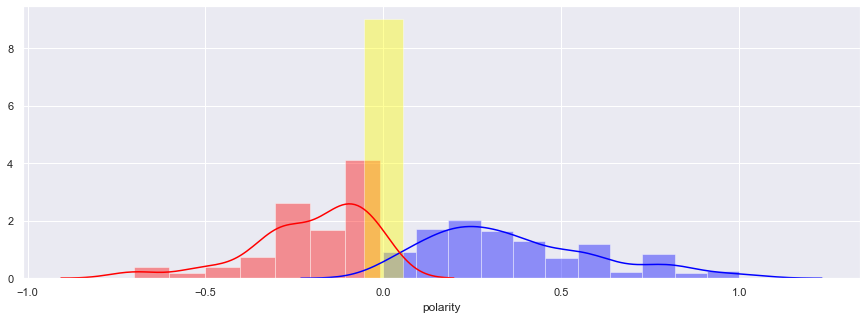

In [27]:
# Distribution of polarity for different sentiment (positive, negative, neutral)
plt.figure(figsize=(15,5))
sns.distplot(data.loc[data.sentiment=='Positive','polarity'],color='blue')
sns.distplot(data.loc[data.sentiment=='Negative','polarity'],color='red')
sns.distplot(data.loc[data.sentiment=='Neutral','polarity'],color='yellow')
plt.show()

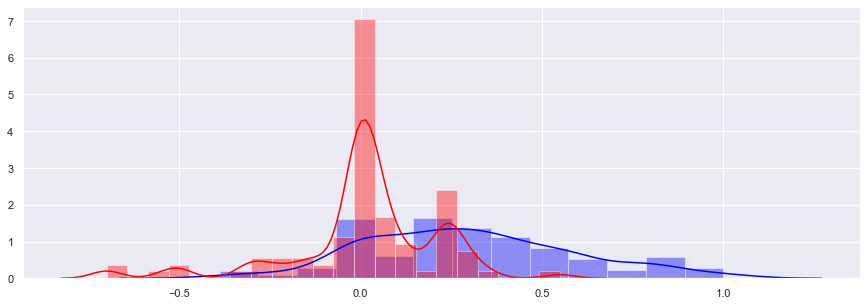

In [28]:
# Distribution of polarity for different star rating given by customer
plt.figure(figsize=(15,5))
sns.distplot(data.loc[data.Stars==5,['polarity']],color='blue')
sns.distplot(data.loc[data.Stars==1,['polarity']],color='red')
plt.show()

## Identify key themes of problems (using clustering, topic models)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
vectorizer.fit(data['Clean_Reviews'])
X_train = vectorizer.transform(data['Clean_Reviews']).toarray()

In [30]:
from sklearn.cluster import KMeans

Km = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1, random_state=5)
res = Km.fit(X_train)

In [31]:
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)

cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [32]:
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))

words = list(words)
print(words)

['loan', 'answer', 'alway', 'busi', 'fred', 'abl', 'alex', 'know', 'profession', 'use', 'day', 'begin', 'compani', 'team', 'peter', 'end', 'friend', 'servic', 'servic alway', 'process', 'jon', 'close', 'work', 'great', 'custom servic', 'steve', 'rate', 'help', 'easi', 'time', 'mortgag', 'respons', 'thank', 'recommend', 'day close', 'thing', 'question', 'nick', 'home', 'great work', 'got', 'purchas', 'loan close', 'custom']


In [33]:
# getting the cluster centers and features
centroids = res.cluster_centers_.argsort()[:, ::-1]
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)

for i in range(len(res.cluster_centers_)):
    print('\n Cluster %d:' % i, end='\n \t')
    for ind in centroids[i, :10]:
        print('%s' % vocab[ind], end=', ')


 Cluster 0:
 	close, abl, help, loan, time, loan close, end, rate, begin, know, 
 Cluster 1:
 	servic, compani, mortgag, loan, custom, custom servic, use, busi, recommend, process, 
 Cluster 2:
 	alway, great, work, respons, fred, great work, servic, process, servic alway, alex, 
 Cluster 3:
 	got, steve, day, work, thing, close, respons, day close, friend, nick, 
 Cluster 4:
 	team, profession, answer, time, question, close, great, work, peter, home, 
 Cluster 5:
 	process, home, loan, help, work, easi, recommend, jon, thank, purchas, 

## Predicting star ratings using reviews

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score, mean_squared_error, mean_absolute_error,
roc_curve, auc, classification_report, confusion_matrix)

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [35]:
# Different models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ADABC', AdaBoostClassifier()))
models.append(('NB', GaussianNB()))
models.append(('ETC', ExtraTreeClassifier()))
models.append(('XGBC', XGBClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('MLPC', MLPClassifier()))
models.append(('SVCL', svm.SVC(kernel='linear')))

#### TfidfVectorizer of clean text and Train Test split

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vector = TfidfVectorizer()

X = tf_vector.fit_transform(data['Clean_Reviews']).toarray()
y = data['Stars'].values

In [37]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [38]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring='roc_auc', n_jobs=-1)
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.977844 (0.032428)
RFC: 0.955571 (0.036794)
KNN: 0.942495 (0.054963)
CART: 0.800935 (0.076855)
ADABC: 0.909362 (0.044201)
NB: 0.785726 (0.066031)
ETC: 0.775977 (0.033180)
XGBC: 0.950381 (0.028675)
GBC: 0.904878 (0.029766)
MLPC: 0.978031 (0.031610)
SVCL: 0.978387 (0.031266)


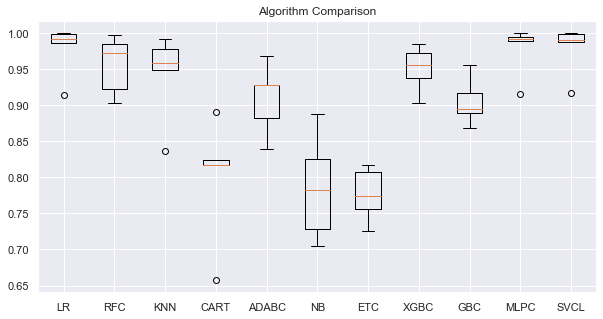

In [39]:
# Compare Algorithms
plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [40]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True)
models_df

,Model,Score
10,SVCL,97.8387
9,MLPC,97.8031
0,LR,97.7844
1,RFC,95.5571
7,XGBC,95.0381
2,KNN,94.2495
4,ADABC,90.9362
8,GBC,90.4878
3,CART,80.0935
5,NB,78.5726


# model

In [41]:
gscv_svc = GridSearchCV(estimator = svm.SVC(kernel='linear', gamma='auto', probability=True, random_state=42), 
                     param_grid={},
                     scoring = 'roc_auc',
                     cv = 10,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   12.0s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.8s finished


In [42]:
gscv_svc.best_estimator_

SVC(gamma='auto', kernel='linear', probability=True, random_state=42)

In [43]:
gscv_svc.best_score_

0.9805801860974276

In [44]:
svc = gscv_svc.best_estimator_
svc.fit(train_x, train_y)

# Making prediction on train and test data
svc_train_pred = svc.predict(train_x)
svc_test_pred = svc.predict(test_x)

# Calculating log loss
ll_svc = metrics.log_loss(test_y, svc.predict_proba(test_x))

In [45]:
print("Model Pesvcormance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, svc_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, svc_train_pred))
print("")
print("Test Dataset")
acc_svc = metrics.accuracy_score(test_y, svc_test_pred)
print("Accuracy : ", acc_svc)
print("AUC      : ", metrics.roc_auc_score(test_y, svc_test_pred))
print("Log Loss : ", ll_svc)

Model Pesvcormance
Train Dataset
Accuracy :  0.9971671388101983
AUC      :  0.9918032786885246

Test Dataset
Accuracy :  0.9407894736842105
AUC      :  0.8781156530408774
Log Loss :  0.14833896533555735


In [46]:
#Getting classification metrics scores
print(metrics.classification_report(test_y, svc_test_pred))

              precision    recall  f1-score   support

           1       0.96      0.76      0.85        34
           5       0.94      0.99      0.96       118

    accuracy                           0.94       152
   macro avg       0.95      0.88      0.91       152
weighted avg       0.94      0.94      0.94       152



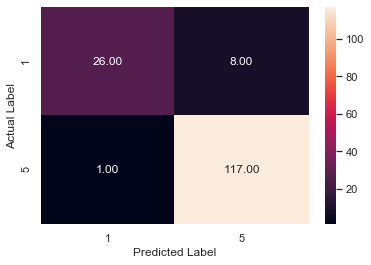

In [47]:
confusion_matrix = metrics.confusion_matrix(test_y, svc_test_pred, labels = [1,5])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['1','5'], 
            yticklabels = ['1','5'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()